In [1345]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from kerastuner.tuners import RandomSearch
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Read the CSV file into a DataFrame
df = pd.read_csv('Updated_FinalFilteredCombined.csv')

# Display the first 5 rows
print(df.head())

# Print the column names and their data types
print(df.info())

   index  AADT_VN  BEGIN_POIN  COUNTY_COD  END_POINT  IRI_VN  IS_IMPROVED  \
0      0    44290         5.3          97        5.4      44            0   
1      1    44750         5.3          97        5.4      48            0   
2      2    45760         5.3          97        5.4      80            0   
3      3    48670         5.3          97        5.4      43            1   
4      4    49080         5.3          97        5.4      39            1   

       ROUTE_ID  SPEED_LIMI  THROUGH_LA  YEAR_RECOR  curval  \
0  IN0000100000        60.0           4        2013     263   
1  IN0000100000        60.0           4        2014     268   
2  IN0000100000        60.0           4        2015     192   
3  IN0000100000        70.0           4        2016     176   
4  IN0000100000        70.0           4        2017     205   

                                      geometry_paths  tmiles  tons  value  
0  [[[-88.31770505199995, 30.49976574300007], [-8...      15   716    270  
1  [[[

In [1346]:
print(df.columns)

Index(['index', 'AADT_VN', 'BEGIN_POIN', 'COUNTY_COD', 'END_POINT', 'IRI_VN',
       'IS_IMPROVED', 'ROUTE_ID', 'SPEED_LIMI', 'THROUGH_LA', 'YEAR_RECOR',
       'curval', 'geometry_paths', 'tmiles', 'tons', 'value'],
      dtype='object')


In [1347]:
df_2022 = df[df['YEAR_RECOR'] == 2022]

In [1348]:
df = df[df['YEAR_RECOR'] != 2022]

In [1349]:
df.index = range(1, len(df) + 1)
df.reset_index(inplace=True, names=['new_index'])  # Add 'new_index' as a column

# Method 2: Creating a new column directly
df['new_index'] = range(1, len(df) + 1)

# If you want 'index' instead of 'new_index'
df.rename(columns={'new_index': 'index'}, inplace=True)

In [1350]:
df['index'] = df['index'] + 1

In [1351]:
train_months = df['index']

In [1352]:
cols = ['AADT_VN', 'BEGIN_POIN', 'COUNTY_COD', 'END_POINT', 'IS_IMPROVED', 'SPEED_LIMI', 'THROUGH_LA', 'YEAR_RECOR', 'curval', 'tmiles', 'tons', 'value']
target_col = 'IRI_VN'

In [1353]:
df_for_training = df[cols + [target_col]]  

In [1354]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [1355]:
trainX = []
trainY = []

In [1356]:
n_future = 1
n_past = 9

In [1357]:
for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:len(cols)])  # Only features
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, len(cols)])

In [1358]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [1359]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (6319, 9, 12).
trainY shape == (6319, 1).


In [1360]:
print(trainY)

[[-0.50681722]
 [-0.11282636]
 [-0.5247259 ]
 ...
 [ 1.21241565]
 [ 5.56422385]
 [ 1.40941108]]


In [1361]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

In [1362]:
from tensorflow.keras.regularizers import l2, l1, l1_l2

model = Sequential()
model.add(LSTM(96, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer= l1(0.0001)))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=True, kernel_regularizer= l1(0.0001)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', return_sequences=False, kernel_regularizer= l1(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1], kernel_regularizer= l1(0.0001)))

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0004)
model.compile(optimizer=optimizer, loss='mse')
model.summary()


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_101 (LSTM)                 │ (None, 9, 96)          │        41,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 9, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_102 (LSTM)                 │ (None, 9, 64)          │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_103 (LSTM)                 │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,521 (373.13 KB)

 Trainable params: 95,521 (373.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
285/285 ━━━━━━━━━━━━━━━━━━━━ 67s 36ms/step - loss: 1.1760 - val_loss: 1.1764
Epoch 2/150
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.0176 - val_loss: 1.0608
Epoch 3/150
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.8293 - val_loss: 0.9663
Epoch 4/150
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.8660 - val_loss: 0.9098
Epoch 5/150
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8262 - val_loss: 0.8765
Epoch 6/150
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7890 - val_loss: 0.8589
Epoch 7/150
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.7191 - val_loss: 0.8461
Epoch 8/150
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.7512 - val_loss: 0.8223
Epoch 9/150
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7357 - val_loss: 0.8128
Epoch 10/150
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7131 - val_loss: 0.8095
Epoch 11/150
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7152 - val_loss: 0.7879
Epoch 12/150
285/285 ━━━━━━━━

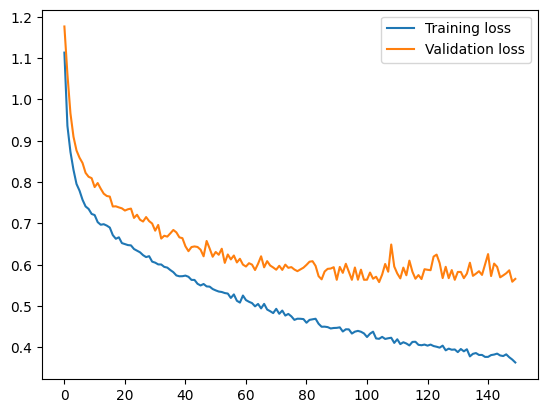

In [1364]:
history = model.fit(X_train, y_train, epochs=150, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [1365]:
y_pred = model.predict(X_test)

y_pred_original = np.zeros((y_pred.shape[0], df_for_training.shape[1])) # Dummy array with correct number of columns
y_pred_original[:, -1] = y_pred[:, 0]  # Place predictions in the last column
y_pred_original = scaler.inverse_transform(y_pred_original)[:, -1]

40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 807ms/step


In [1366]:
# Create a dummy array for y_test as well
y_test_original = np.zeros((y_test.shape[0], df_for_training.shape[1]))
y_test_original[:, -1] = y_test[:, 0]
y_test_original = scaler.inverse_transform(y_test_original)[:, -1]

In [1367]:
print(y_pred_original)
print(y_test_original)

[ 57.67874386  50.93126208  60.94052724 ...  48.51411002  66.96318491
 157.5923453 ]
[ 62.  37.  54. ...  44.  69. 113.]


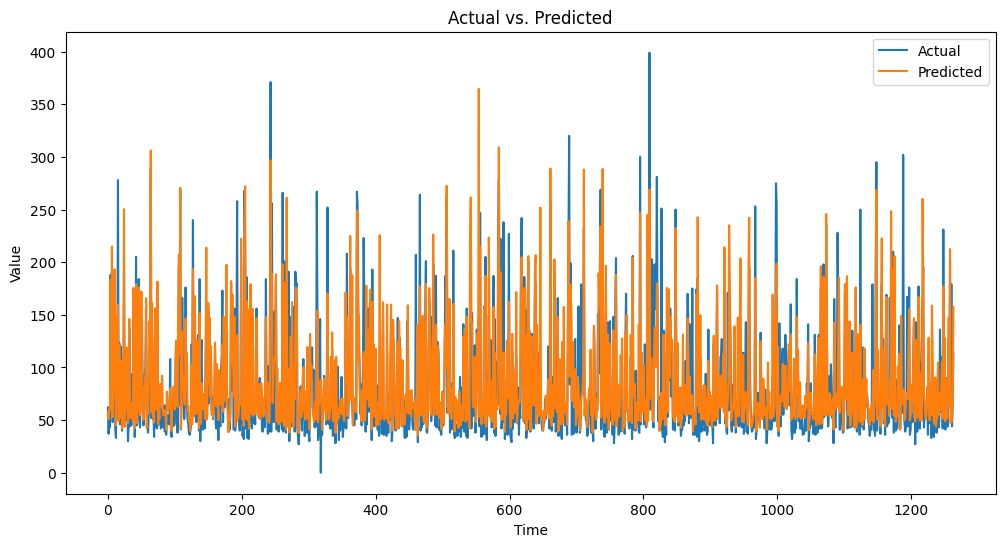

In [1368]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(y_pred_original, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

In [1369]:
mse = mean_squared_error(y_test_original, y_pred_original)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1090.4399417213044


In [1370]:
from sklearn.metrics import r2_score

# Calculate R² for the training set
y_train_pred = model.predict(X_train)

y_train_pred_original = np.zeros((y_train_pred.shape[0], df_for_training.shape[1]))
y_train_pred_original[:, -1] = y_train_pred[:, 0]
y_train_pred_original = scaler.inverse_transform(y_train_pred_original)[:, -1]

y_train_original = np.zeros((y_train.shape[0], df_for_training.shape[1]))
y_train_original[:, -1] = y_train[:, 0]
y_train_original = scaler.inverse_transform(y_train_original)[:, -1]

r2_train = r2_score(y_train_original, y_train_pred_original)
print(f'R² score for training set: {r2_train}')

# Calculate R² for the test set
y_test_pred = model.predict(X_test)

y_test_pred_original = np.zeros((y_test_pred.shape[0], df_for_training.shape[1]))
y_test_pred_original[:, -1] = y_test_pred[:, 0]
y_test_pred_original = scaler.inverse_transform(y_test_pred_original)[:, -1]

y_test_original = np.zeros((y_test.shape[0], df_for_training.shape[1]))
y_test_original[:, -1] = y_test[:, 0]
y_test_original = scaler.inverse_transform(y_test_original)[:, -1]

r2_test = r2_score(y_test_original, y_test_pred_original)
print(f'R² score for test set: {r2_test}')

158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
R² score for training set: 0.7195352551258741
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
R² score for test set: 0.6499651034933136


In [ ]:
def build_model(hp):
    model_hp = Sequential()
    model_hp.add(LSTM(hp.Int('units_lstm1', min_value=64, max_value=512, step=64),
                   return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   activation='relu'))

    model_hp.add(LSTM(hp.Int('units_lstm2', min_value=32, max_value=512, step=32),
                   return_sequences=False,
                   activation='relu'))
    model_hp.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=1.0, step=0.1)))
    model_hp.add(Dense(trainY.shape[1]))

    model_hp.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mse')
    return model_hp

In [ ]:
tuner_hp = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,      
    executions_per_trial=3, 
    directory='tuning_dir',
    project_name='hp_1'
)

In [ ]:
tuner_hp.search_space_summary()

In [ ]:
tuner_hp.search(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, verbose=1)

In [ ]:
tuner_hp.results_summary()


In [ ]:
best_model = tuner_hp.get_best_models(num_models=1)[0]
print(best_model)


In [ ]:
y_train_pred_hp = best_model.predict(X_train)
y_test_pred_hp = best_model.predict(X_test)

In [ ]:
# Inverse transform the predictions (assuming 'scaler' is your StandardScaler)
y_train_pred_hp = np.zeros((y_train_pred_hp.shape[0], df_for_training.shape[1]))
y_train_pred_hp[:, -1] = y_train_pred_hp[:, 0]
y_train_pred_hp = scaler.inverse_transform(y_train_pred_hp)[:, -1]

y_train_original = np.zeros((y_train.shape[0], df_for_training.shape[1]))
y_train_original[:, -1] = y_train[:, 0]
y_train_original = scaler.inverse_transform(y_train_original)[:, -1]

y_test_pred_hp = np.zeros((y_test_pred_hp.shape[0], df_for_training.shape[1]))
y_test_pred_hp[:, -1] = y_test_pred_hp[:, 0]
y_test_pred_hp = scaler.inverse_transform(y_test_pred_hp)[:, -1]

y_test_original = np.zeros((y_test.shape[0], df_for_training.shape[1]))
y_test_original[:, -1] = y_test[:, 0]
y_test_original = scaler.inverse_transform(y_test_original)[:, -1]

In [ ]:
from sklearn.metrics import r2_score


r2_train = r2_score(y_train_original, y_train_pred_hp)
r2_test = r2_score(y_test_original, y_test_pred_hp)

print(f'Best Model Training R²: {r2_train}')
print(f'Best Model Test R²: {r2_test}')